# Multivariate Analysis

## References
[statsmodels.tsa.vector_ar.vecm](https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.VECM.html)

[Time-series Analysis with VAR & VECM: Statistical approach](https://towardsdatascience.com/vector-autoregressions-vector-error-correction-multivariate-model-a69daf6ab618)

[GSoC 2016: VECM](https://gist.github.com/yogabonito/5461b26bed335cad6907aa4e613acb99)


In [1]:
import pandas as pd
import os
import numpy as np
%matplotlib inline

In [2]:
#load csv files into dataframes
data_frames = {}
for file in os.listdir():
    if file.find('.csv')!=-1:
        try:
            data_frames[file] = pd.read_csv(file)
        except:
            print(file)

In [3]:
#load CAD/USD exchange rate
exchange_rate = data_frames['AEXCAUS.csv']
exchange_rate['DATE']=exchange_rate['DATE'].astype(str).str[0:4].astype(int)
exchange_rate = exchange_rate.set_index('DATE')

In [4]:
#get cpi data
cpi_ir = data_frames['DP_LIVE_10102020213754370.csv']\
[data_frames['DP_LIVE_10102020213754370.csv'].LOCATION!='OECD']\
.pivot(index='TIME',columns='LOCATION',values='Value')\
.dropna()
cpi_ir['CPI_IR']=cpi_ir['CAN']-cpi_ir['USA']

In [5]:
#get interest rate data
ri_ir = data_frames['DP_LIVE_10102020214019137.csv']\
[data_frames['DP_LIVE_10102020214019137.csv'].LOCATION!='OECD']\
.pivot(index='TIME',columns='LOCATION',values='Value')\
.dropna()
ri_ir['INT_IR']=ri_ir['CAN']-ri_ir['USA']

In [6]:
#get terms of trade data
tot = data_frames['DP_LIVE_10102020213123395.csv']\
[data_frames['DP_LIVE_10102020213123395.csv'].LOCATION!='OECD']\
.pivot(index='TIME',columns='LOCATION',values='Value')\
.dropna()
tot['tot']=tot['CAN']

In [7]:
# difference between CAD and USA federal debt as percentage of gdp
debt = pd.concat([data_frames['GGGDTACAA188N.csv'].set_index('DATE'),
                  data_frames['DEBTTLUSA188A.csv'].set_index('DATE')],axis=1).dropna()
debt['rel_debt']=debt['GGGDTACAA188N']-debt['DEBTTLUSA188A']
debt = debt.reset_index()
debt['index']=debt['index'].astype(str).str[:4].astype(int)
debt=debt.set_index('index')

In [8]:
#oil data
oil = data_frames['DCOILWTICO.csv']
oil['DATE']=oil['DATE'].astype(str).str[:4].astype(int)
oil = oil.set_index('DATE')

In [9]:
#merge data on year/date/time index
data = pd.concat([exchange_rate['AEXCAUS'],
           np.log(oil['DCOILWTICO']),
           np.log(tot['tot']),
           cpi_ir['CPI_IR'],
           debt['rel_debt'],
           ri_ir['INT_IR']
          ],
          axis=1).dropna()

In [10]:
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order
#print the k_ar_diff order using aic for nc model
nc_lags = select_order(data,maxlags=2,deterministic='nc')
print(nc_lags.summary())
print("nc lags based on aic: ",nc_lags.aic)

 VECM Order Selection (* highlights the minimums)
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -15.87      -13.82   1.407e-07      -15.30
1      -18.65      -14.85   1.559e-08      -17.60
2     -29.73*     -24.17*  2.085e-12*     -28.19*
-------------------------------------------------
nc lags based on aic:  2


/Users/pepar-mapillary/anaconda3/envs/monthly-report/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pepar-mapillary/anaconda3/envs/monthly-report/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pepar-mapillary/anaconda3/envs/monthly-report/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [11]:
#trace rank
#k_ar_diff set to 1 since all variables are unit root at diff = 1
vec_rank = select_coint_rank(data, det_order = -1, k_ar_diff = nc_lags.aic, method = 'trace', signif=0.05)
print(vec_rank.summary())

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   6          229.7          83.94
  1   6          137.9          60.06
  2   6          84.75          40.17
  3   6          44.69          24.28
  4   6          13.81          12.32
  5   6          3.979          4.130
-------------------------------------


In [12]:
#print trace rank
print("trace cointegration rank: ", vec_rank.rank)

trace cointegration rank:  5


In [13]:
#eigen rank
#k_ar_diff set to 1 since all variables are unit root at diff = 1
vec_rank2 = select_coint_rank(data, det_order = -1, k_ar_diff = nc_lags.aic, method = 'maxeig', signif=0.05)
print(vec_rank2.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          91.87          36.63
  1   2          53.11          30.44
  2   3          40.06          24.16
  3   4          30.88          17.80
  4   5          9.827          11.22
-------------------------------------


In [14]:
#print max eigen rank
print("max eigen cointegration rank: ", vec_rank2.rank)

max eigen cointegration rank:  4


In [15]:
## fit model nc model
#k_ar_diff set to 3
#coint_rank set to 4
vecm = VECM(endog = data, k_ar_diff = 2, coint_rank =4, deterministic = 'nc')
vecm_fit = vecm.fit()

/Users/pepar-mapillary/anaconda3/envs/monthly-report/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<AxesSubplot:title={'center':'CAD/USD FX Equilibrium vs Actuals Overtime'}, xlabel='Year', ylabel='CAD/USD'>

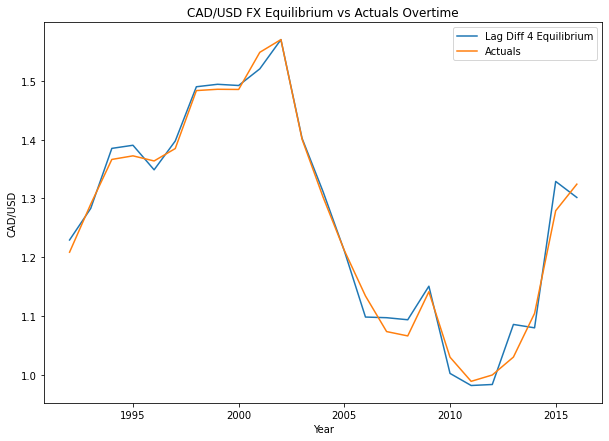

In [16]:
#create plot for equilbirum exchange vs acutal exchange
nc_equilibrium = pd.DataFrame(vecm_fit.resid)[0].values + data['AEXCAUS'].iloc[3:].values
pd.DataFrame([pd.DataFrame(vecm_fit.resid)[0].values + data['AEXCAUS'].iloc[3:].values,
              data['AEXCAUS'].iloc[3:].values],
             index=['Lag Diff 4 Equilibrium','Actuals'],
             columns=data['AEXCAUS'].iloc[3:].index)\
.T\
.plot(figsize=(10,7),
      title = 'CAD/USD FX Equilibrium vs Actuals Overtime',
      xlabel = 'Year',
      ylabel = 'CAD/USD'
     )

/Users/pepar-mapillary/anaconda3/envs/monthly-report/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<AxesSubplot:title={'center':'CAD/USD FX Equilibrium vs Actuals Overtime - Lag Diffs 4 and 5'}, xlabel='Year', ylabel='CAD/USD'>

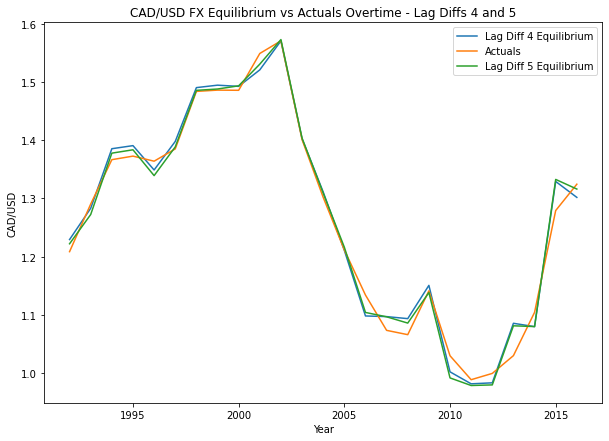

In [17]:
#try the alternative rank of 5
vecm = VECM(endog = data, k_ar_diff = nc_lags.aic, coint_rank =5, deterministic = 'nc')
vecm_fit = vecm.fit()
#create plot for equilbirum exchange vs acutal exchange
pd.DataFrame([nc_equilibrium,
              data['AEXCAUS'].iloc[3:].values,
             pd.DataFrame(vecm_fit.resid)[0].values + data['AEXCAUS'].iloc[3:].values],
             index=['Lag Diff 4 Equilibrium','Actuals','Lag Diff 5 Equilibrium'],
             columns=data['AEXCAUS'].iloc[3:].index)\
.T\
.plot(figsize=(10,7),
      title = 'CAD/USD FX Equilibrium vs Actuals Overtime - Lag Diffs 4 and 5',
      xlabel = 'Year',
      ylabel = 'CAD/USD'
     )

In [18]:


#export to other file formats
!jupyter nbconvert --to html "multivariate_analysis.ipynb"
!jupyter nbconvert --to python "multivariate_analysis.ipynb"



[NbConvertApp] Converting notebook multivariate_analysis.ipynb to html
[NbConvertApp] Writing 398844 bytes to multivariate_analysis.html
[NbConvertApp] Converting notebook multivariate_analysis.ipynb to python
[NbConvertApp] Writing 5130 bytes to multivariate_analysis.py
